In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline 
import json
import urllib2
import zipfile
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


#1. Get and prep your data.

In [2]:
#Loading and concatenating Census files
census_years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
                '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
full_years = ['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', 
              '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']
census_files = []
census_est = {}

for i in census_years:
    file_path = 'zbp%stotals.zip' % i
    census_zip = zipfile.ZipFile(file_path) 
    census_year = pd.read_csv(census_zip.open(file_path.replace('.zip','.txt')))
    census_year.columns = [x.upper() for x in census_year.columns]
    census_year = census_year[['ZIP', 'EST']]
    census_year = census_year.rename(columns = {'EST':i})
    census_files.append(census_year)

census_est[0] = census_files[0]

for i in range(1,20):
    census_est[i] = pd.merge(census_files[i], census_est[i-1], on=['ZIP']) 
    
census_df = census_est[19]
census_df = census_df.set_index('ZIP', drop = True)
census_df = census_df.reindex_axis([['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
                                     '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']], axis=1)
census_df.columns = full_years
census_df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ZIP,,,,,,,,,,,,,,,,,,,,
1001,439,439,433,457,444,469,493,490,490,505,500,509,509,503,477,458,448,436,453,439
1002,450,467,487,500,490,558,563,587,566,586,584,589,582,596,584,571,570,558,572,572
1003,10,10,13,15,14,13,13,13,15,16,15,12,12,16,17,16,16,16,15,15
1004,47,48,47,41,31,35,48,37,23,21,43,31,30,20,18,18,21,19,16,16
1005,92,95,101,104,95,82,86,90,94,93,97,94,98,106,97,87,96,91,94,97


In [3]:
#Loading GeoJSON file
zip_url = 'https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson'
request = urllib2.urlopen(zip_url)
zip_data = json.load(request)

In [4]:
#Getting list of zipcodes from GeoJSON file
ziplist = []

for i in range(len(zip_data['features'])):
    zipcode = zip_data['features'][i]['properties']['postalCode']
    ziplist.append(zipcode)
    
ziplist = map(int, ziplist)

In [5]:
#Excluding non-NYC data
census_mask = census_df.index.isin(ziplist)
census_df = census_df[census_mask]
census_df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ZIP,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


In [6]:
#Converting dataframe into matrix
census_matrix = census_df.as_matrix()
census_matrix

array([[6999, 7088, 7075, ..., 7227, 7235, 7273],
       [1784, 1819, 1919, ..., 2912, 2954, 2988],
       [3256, 3377, 3417, ..., 4159, 4214, 4277],
       ..., 
       [  95,   90,   88, ...,  131,  129,  127],
       [ 294,  285,  287, ...,  326,  326,  327],
       [  33,   32,   34, ...,   46,   49,   40]])

In [7]:
#Performing z-score normalization of each time series
census_norm = np.zeros(census_matrix.shape)

for i in range(len(census_matrix)):
    census_norm[i] = stats.zscore(census_matrix[i])
    
print census_norm.shape
print census_norm.mean(axis=1)
print census_norm.std(axis=1)

(230, 20)
[ -2.72004641e-15  -4.55191440e-16   2.33146835e-16   7.88258347e-16
  -1.64868119e-15   2.77555756e-16  -3.21964677e-16   1.11022302e-16
   1.27675648e-15  -1.05471187e-15   1.11022302e-17   4.16680579e-16
   4.44089210e-16   6.27969898e-17   1.57651669e-15   8.88178420e-16
   3.33066907e-17   6.43929354e-16   2.22044605e-17   1.05471187e-15
   2.44249065e-15   1.11022302e-17  -3.10862447e-16  -2.22044605e-17
  -4.66293670e-16  -2.77555756e-18  -1.44328993e-16  -3.44169138e-16
  -5.21804822e-16   4.44089210e-17  -7.21644966e-16   4.44089210e-17
  -9.99200722e-17  -1.47659662e-15  -3.33066907e-17  -1.11022302e-17
  -4.44089210e-17  -5.99520433e-16   2.33146835e-16  -3.33066907e-17
  -1.77635684e-16   7.77156117e-17  -1.11022302e-17   2.22044605e-16
  -2.44249065e-16   1.53609764e-16  -1.66533454e-16   3.51108032e-16
  -5.32907052e-16   3.66373598e-16   4.66293670e-16   1.66533454e-17
   2.22044605e-17  -2.77555756e-16   3.27515792e-16  -2.44249065e-16
  -2.16493490e-16   3.33

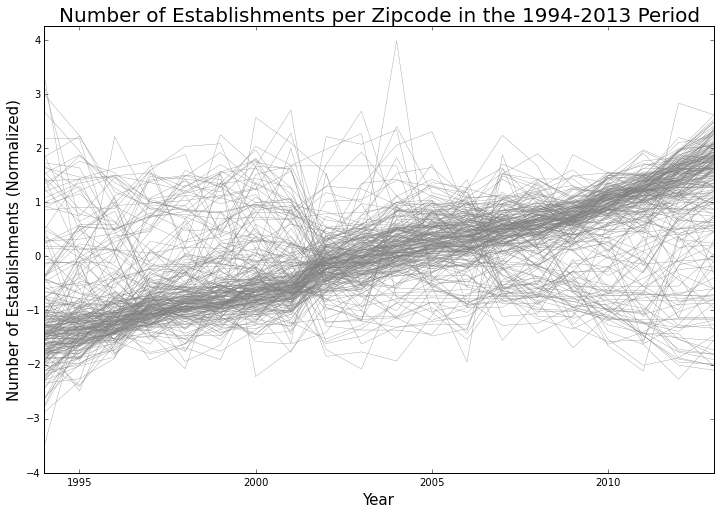

In [8]:
#Plotting the data
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color='gray', linewidth=0.3)
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Number of Establishments per Zipcode in the 1994-2013 Period", fontsize=20)

#2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
# + 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

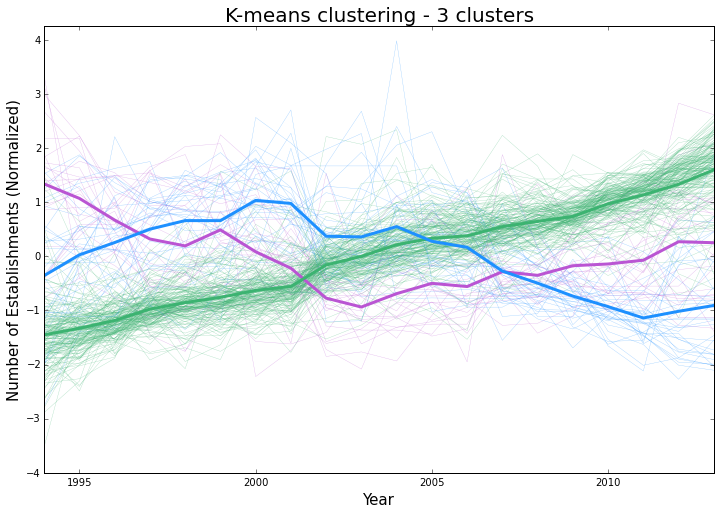

In [9]:
#K-means clustering; k=3
kmeans3 = KMeans(n_clusters=3, n_init=100)
kmeans3.fit(census_norm)
labels3 = kmeans3.labels_

#Calculating cluster centers
kc3_d = np.zeros((3,230))
kc3_m = np.zeros((3,230,20))
kc3 = np.zeros((3,20))

for k in range(3):
    
    for i in range(230):
        if labels3[i] == k:
            kc3_d[k][i] = 1
        else:
            kc3_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc3_m[k][b][a] = kc3_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc3[k][i] = map(sum, kc3_m[k].transpose())[i]/kc3_d[k].sum()

#Plotting        
colormap = ['mediumorchid', 'mediumseagreen', 'dodgerblue', 'rosybrown', 'slategrey']

pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels3[i]], linewidth=0.3, alpha=0.5)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(3):
    pl.plot(full_years, kc3[i], '-', color=colormap[i], linewidth=3)

xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means clustering - 3 clusters", fontsize=20)

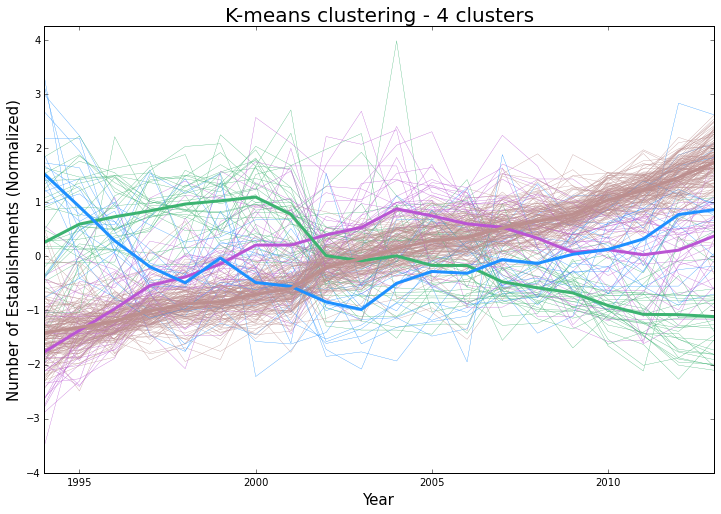

In [10]:
#K-means clustering; k=4

kmeans4 = KMeans(n_clusters=4, n_init=100)
kmeans4.fit(census_norm)
labels4 = kmeans4.labels_

#Calculating cluster centers
kc4_d = np.zeros((4,230))
kc4_m = np.zeros((4,230,20))
kc4 = np.zeros((4,20))

for k in range(4):
    
    for i in range(230):
        if labels4[i] == k:
            kc4_d[k][i] = 1
        else:
            kc4_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc4_m[k][b][a] = kc4_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc4[k][i] = map(sum, kc4_m[k].transpose())[i]/kc4_d[k].sum()

#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels4[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(4):
    pl.plot(full_years, kc4[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means clustering - 4 clusters", fontsize=20)

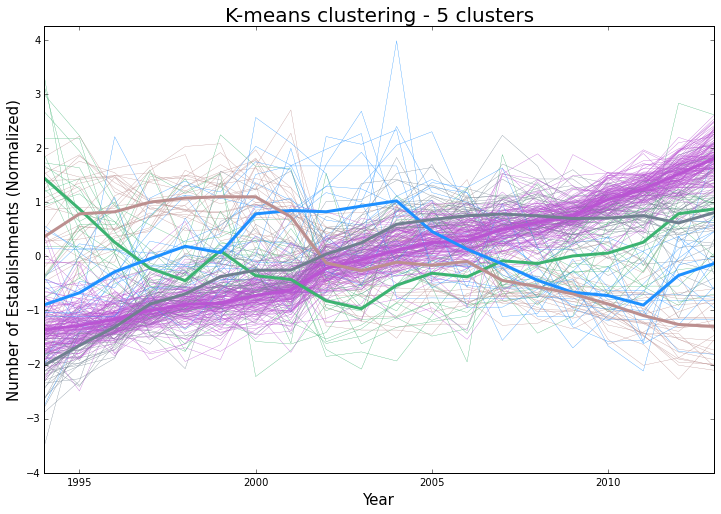

In [11]:
#K-means clustering; k=5

kmeans5 = KMeans(n_clusters=5, n_init=100)
kmeans5.fit(census_norm)
labels5 = kmeans5.labels_

#Calculating cluster centers
kc5_d = np.zeros((5,230))
kc5_m = np.zeros((5,230,20))
kc5 = np.zeros((5,20))

for k in range(5):
    
    for i in range(230):
        if labels5[i] == k:
            kc5_d[k][i] = 1
        else:
            kc5_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            kc5_m[k][b][a] = kc5_d[k][b]*census_norm[b][a]

    for i in range(20):
        kc5[k][i] = map(sum, kc5_m[k].transpose())[i]/kc5_d[k].sum()

#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labels5[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(5):
    pl.plot(full_years, kc5[i], '-', color=colormap[i], linewidth=3)
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("K-means clustering - 5 clusters", fontsize=20)

#4. Use another clustering algorithm (of your choice)

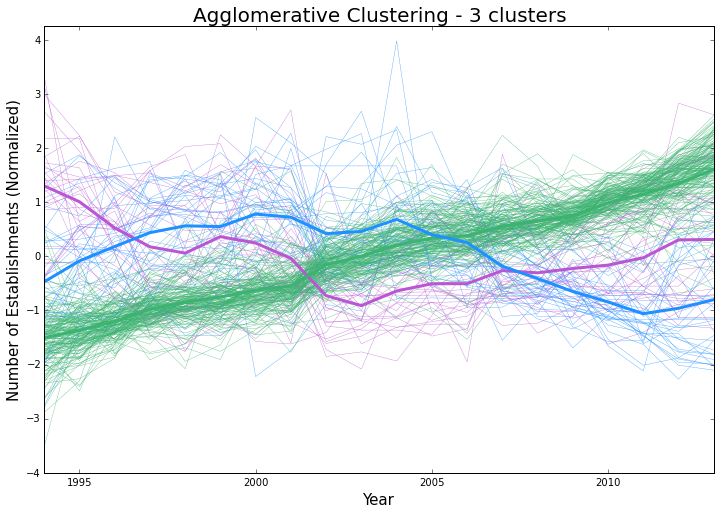

In [12]:
#Agglomerative clustering (3 clusters)
agc3 = AgglomerativeClustering(n_clusters=3,  compute_full_tree=True).fit(census_norm)
labelsag3 = agc3.labels_

#Calculating cluster centers
agc3_d = np.zeros((3,230))
agc3_m = np.zeros((3,230,20))
agc3 = np.zeros((3,20))

for k in range(3):
    
    for i in range(230):
        if labelsag3[i] == k:
            agc3_d[k][i] = 1
        else:
            agc3_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            agc3_m[k][b][a] = agc3_d[k][b]*census_norm[b][a]

    for i in range(20):
        agc3[k][i] = map(sum, agc3_m[k].transpose())[i]/agc3_d[k].sum()

#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labelsag3[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(3):
    pl.plot(full_years, agc3[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Agglomerative Clustering - 3 clusters", fontsize=20)

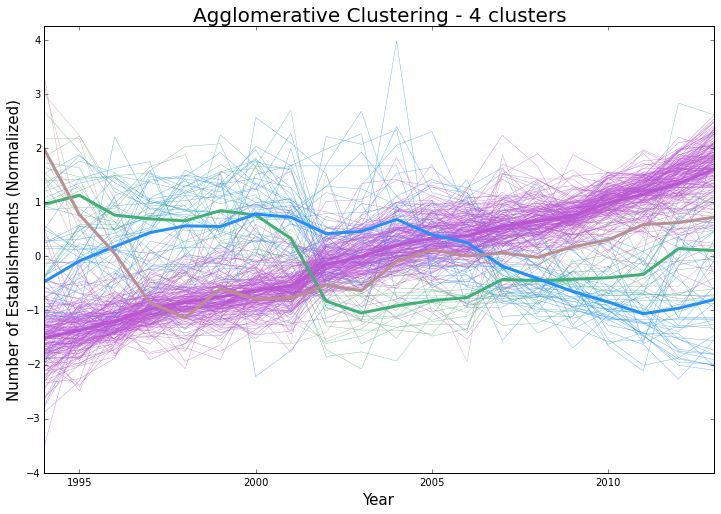

In [13]:
#Agglomerative clustering (4 clusters)
agc4 = AgglomerativeClustering(n_clusters=4,  compute_full_tree=True).fit(census_norm)
labelsag4 = agc4.labels_

#Calculating cluster centers
agc4_d = np.zeros((4,230))
agc4_m = np.zeros((4,230,20))
agc4 = np.zeros((4,20))

for k in range(4):
    
    for i in range(230):
        if labelsag4[i] == k:
            agc4_d[k][i] = 1
        else:
            agc4_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            agc4_m[k][b][a] = agc4_d[k][b]*census_norm[b][a]

    for i in range(20):
        agc4[k][i] = map(sum, agc4_m[k].transpose())[i]/agc4_d[k].sum()

#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labelsag4[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(4):
    pl.plot(full_years, agc4[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Agglomerative Clustering - 4 clusters", fontsize=20)

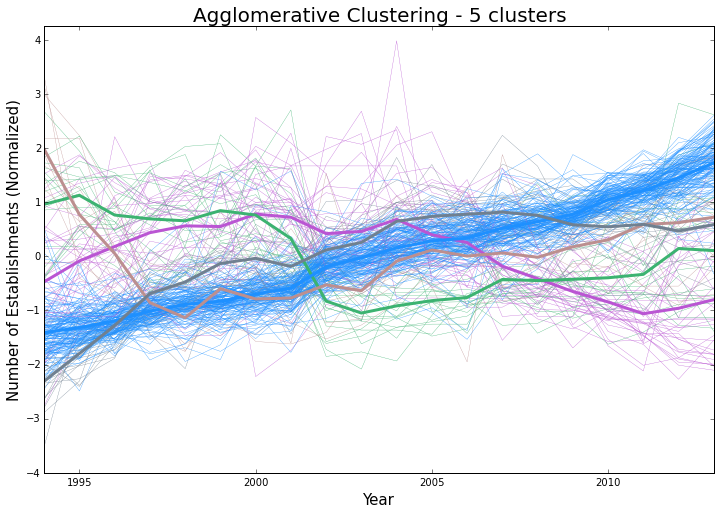

In [14]:
#Agglomerative clustering (5 clusters)
agc5 = AgglomerativeClustering(n_clusters=5,  compute_full_tree=True).fit(census_norm)
labelsag5 = agc5.labels_

#Calculating cluster centers
agc5_d = np.zeros((5,230))
agc5_m = np.zeros((5,230,20))
agc5 = np.zeros((5,20))

for k in range(5):
    
    for i in range(230):
        if labelsag5[i] == k:
            agc5_d[k][i] = 1
        else:
            agc5_d[k][i] = 0

    for a in range(20):        
        for b in range(230):
            agc5_m[k][b][a] = agc5_d[k][b]*census_norm[b][a]

    for i in range(20):
        agc5[k][i] = map(sum, agc5_m[k].transpose())[i]/agc5_d[k].sum()

#Plotting
pl.figure(figsize=(12, 8))
for i in range(len(census_matrix)):
    pl.plot(full_years, census_norm[i], '-', color=colormap[labelsag5[i]], linewidth=0.3)
    xlim(1994,2013)
    ylim(-4.5,4.5)
for i in range(5):
    pl.plot(full_years, agc5[i], '-', color=colormap[i], linewidth=3)    
    
xlim(1994,2013)
ylim(-4,4.25)
pl.xlabel("Year", fontsize=15)
pl.ylabel("Number of Establishments (Normalized)", fontsize=15)
pl.title("Agglomerative Clustering - 5 clusters", fontsize=20)

In [15]:
#Loading map as Geopandas and including columns for clusters
nyc_map = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

cluster_columns = pd.DataFrame(columns=('postalCode', 'km3_cluster', 'km4_cluster', 'km5_cluster', 
                                       'ag3_cluster', 'ag4_cluster', 'ag5_cluster'))

cluster_columns['postalCode'] = census_df.index.astype(str)
cluster_columns['km3_cluster'] = labels3
cluster_columns['km4_cluster'] = labels4
cluster_columns['km5_cluster'] = labels5
cluster_columns['ag3_cluster'] = labelsag3
cluster_columns['ag4_cluster'] = labelsag4
cluster_columns['ag5_cluster'] = labelsag5

nyc_map = pd.merge(nyc_map, cluster_columns, on=['postalCode']) 

nyc_map.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode,km3_cluster,km4_cluster,km5_cluster,ag3_cluster,ag4_cluster,ag5_cluster
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.87440,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1,3,0,1,0,2
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.91390,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,1,3,0,1,0,2
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6269333.41234,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1,3,0,1,0,2
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.05770,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0,2,1,0,3,3
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.59430,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,1,3,0,1,0,2


#5. Overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

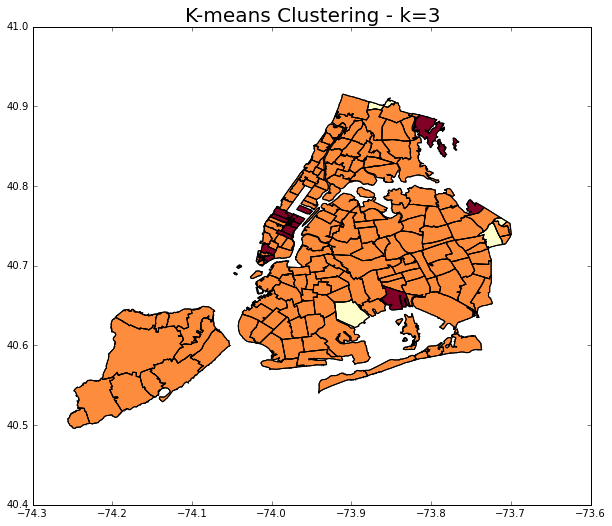

In [16]:
#Plotting k-means in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='km3_cluster', alpha=1, colormap='YlOrRd')
pl.title("K-means Clustering - k=3", fontsize=20)

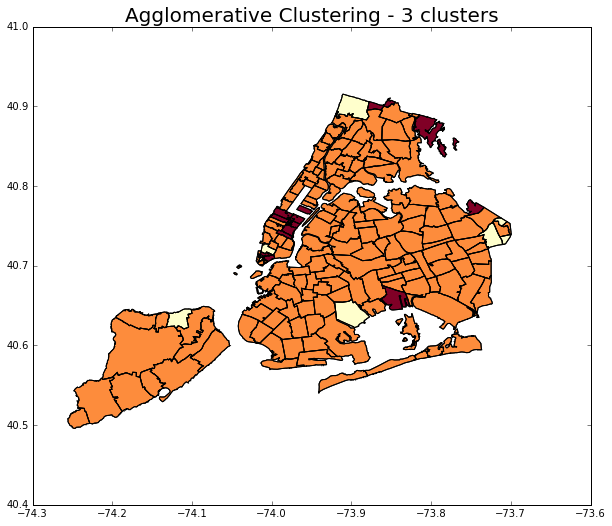

In [17]:
#Plotting agglomerative clustering in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='ag3_cluster', alpha=1, colormap='YlOrRd')
pl.title("Agglomerative Clustering - 3 clusters", fontsize=20)

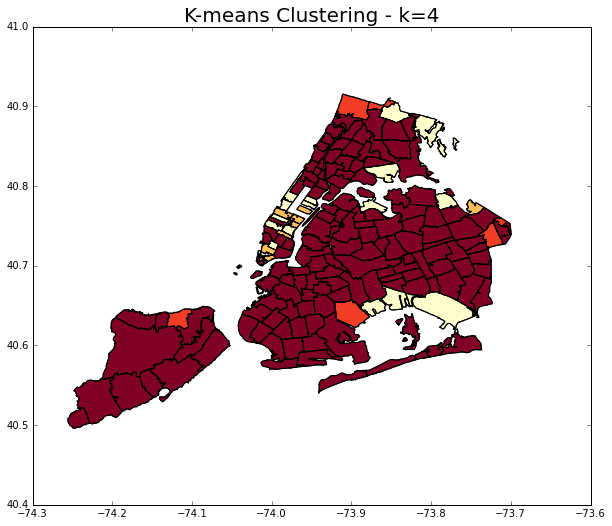

In [18]:
#Plotting k-means in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='km4_cluster', alpha=1, colormap='YlOrRd')
pl.title("K-means Clustering - k=4", fontsize=20)

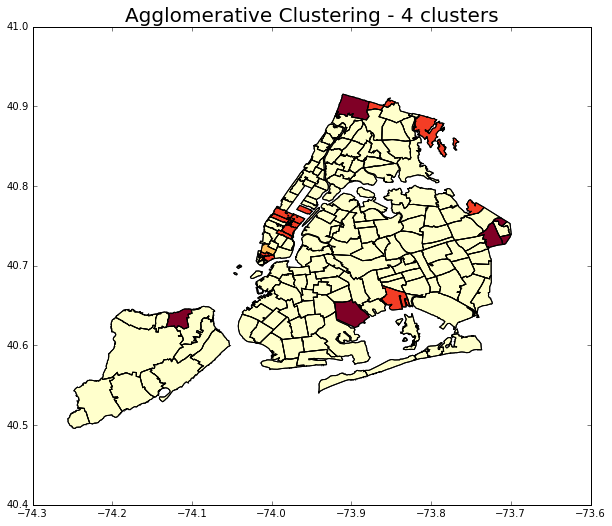

In [19]:
#Plotting agglomerative clustering in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='ag4_cluster', alpha=1, colormap='YlOrRd')
pl.title("Agglomerative Clustering - 4 clusters", fontsize=20)

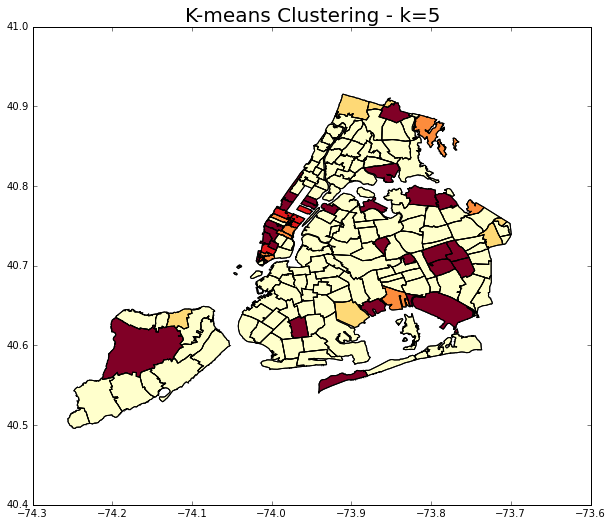

In [20]:
#Plotting k-means in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='km5_cluster', alpha=1, colormap='YlOrRd')
pl.title("K-means Clustering - k=5", fontsize=20)

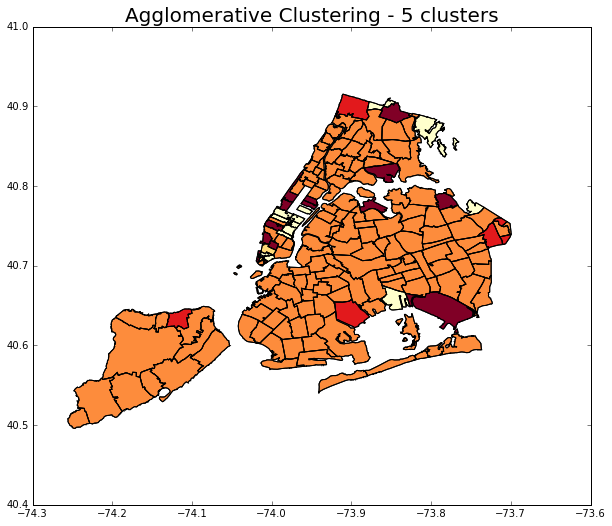

In [21]:
#Plotting agglomerative clustering in map
pl.figure(figsize=(10, 10))
nyc_map.plot(column='ag5_cluster', alpha=1, colormap='YlOrRd')
pl.title("Agglomerative Clustering - 5 clusters", fontsize=20)

#6. Compare the results of the 2 algorithms
#+ 7. Attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

As seen in the plots above, the K-means and Agglomerative Clustering algorithms generate very similar results, with practically the same zip codes composing each of the clusters from this example. Based solely on these analysis, I would say that the area represented by the vast majority of New York City's zipcodes has experienced a sustained and, to a large extent, coordinated expansion in the number of establishments. However, some other trends are observed for other clusters (e.g. stability or decline in the number of establishments). As a researcher, I would focus on the areas have not followed the growth pattern of the remainder of the city, in order to verify actual trends and determine its causes.